In [684]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
from os.path import expanduser
import glob
from matplotlib.ticker import MaxNLocator
from scipy.stats import spearmanr
import seg_metrics.seg_metrics as sg
import pickle
import matplotlib.patches as mpatches
from skimage import exposure
from scipy import ndimage
import nibabel as nib

In [685]:
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SITK version:", sitk.__version__)
print("Scikit-image version:", skimage.__version__)

Python version: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy version: 1.26.2
Matplotlib version: 3.8.2
SITK version: 2.3.1
Scikit-image version: 0.22.0


In [686]:
patient_id = 18

In [687]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)
PREPROCESSED_STACK_DIR = '{}/stack'.format(PREPROCESSED_BASE_DIR)

#### load the Jacobian determinant and calculate the CTVI-Jac

In [688]:
# load images from the Plastimatch (pm) processing
pm_exhale_im = sitk.ReadImage('{}/phase-exhale-nomask.mha'.format(PREPROCESSED_MHA_DIR))
pm_inhale_im = sitk.ReadImage('{}/phase-inhale-nomask.mha'.format(PREPROCESSED_MHA_DIR))
pm_mask_im = sitk.ReadImage('{}/mask-union.mha'.format(PREPROCESSED_MHA_DIR))

pm_exhale_arr = sitk.GetArrayFromImage(pm_exhale_im)
pm_inhale_arr = sitk.GetArrayFromImage(pm_inhale_im)
pm_mask_arr = sitk.GetArrayFromImage(pm_mask_im).astype(bool)

jacobian_det_im = sitk.ReadImage('{}/vf_jac.mha'.format(PREPROCESSED_MHA_DIR))
jacobian_det_arr = sitk.GetArrayFromImage(jacobian_det_im)

In [689]:
jacobian_det_arr.shape

(167, 512, 512)

#### load the PET ground truth

In [690]:
output_name = '{}/Patient{:02d}.npy'.format(PREPROCESSED_STACK_DIR, patient_id)
pt_arr = np.load(output_name)
print('loaded stack from {}'.format(output_name))

exp_arr = pt_arr[0]
insp_arr = pt_arr[1]
pet_arr = pt_arr[2]
pet_labels_arr = pt_arr[3]
mask_arr = pt_arr[4].astype(bool)

loaded stack from /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/stack/Patient18.npy


In [691]:
pet_labels_arr.shape, mask_arr.shape

((301, 500, 500), (301, 500, 500))

In [692]:
prop = np.sum(np.array(jacobian_det_arr[pm_mask_arr]) < 0) / len(jacobian_det_arr[pm_mask_arr].ravel())
print('proportion of voxels with negative values in Jacobian determinant = {}'.format(round(prop, 2)))

proportion of voxels with negative values in Jacobian determinant = 0.0


In [693]:
ctvi_jac_arr = jacobian_det_arr-1.0
ctvi_jac_arr[~pm_mask_arr] = np.min(ctvi_jac_arr)
ctvi_jac_im = sitk.GetImageFromArray(ctvi_jac_arr)

# set the spacing and origin in the CTVI-Jac image
ctvi_jac_im.SetSpacing(jacobian_det_im.GetSpacing())
ctvi_jac_im.SetOrigin(jacobian_det_im.GetOrigin())

In [694]:
ctvi_jac_im.GetSize(), ctvi_jac_im.GetSpacing(), ctvi_jac_im.GetOrigin()

((512, 512, 167),
 (0.9765625, 0.9765625, 1.7999999523162842),
 (-249.51171875, -416.51171875, -483.0))

#### resample, crop, & pad the CTVI-Jac so we can make a comparison with model predictions

In [695]:
# Resampling the images into (1,1,1)mm voxel size. Can use nearest neighbour for interpolation (default is B-spline). 
def resample_image(itk_image, out_spacing=(1.0, 1.0, 1.0), is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [696]:
jacobian_det_im = resample_image(jacobian_det_im)
ctvi_jac_im = resample_image(ctvi_jac_im)

In [697]:
# convert back into numpy array after resampling
jacobian_det_arr = sitk.GetArrayFromImage(jacobian_det_im)
ctvi_jac_arr= sitk.GetArrayFromImage(ctvi_jac_im)

In [698]:
jacobian_det_arr.shape, ctvi_jac_arr.shape

((301, 500, 500), (301, 500, 500))

#### normalise the CTVI-Jac

In [699]:
ctvi_jac_arr = exposure.rescale_intensity(ctvi_jac_arr, in_range='image', out_range=(1e-3,1.))

#### apply a median filter

In [700]:
ctvi_jac_arr = ndimage.median_filter(ctvi_jac_arr, size=7)

#### quantise the CTVI-Jac

In [701]:
percentile_high = np.percentile(ctvi_jac_arr[mask_arr],70)
percentile_medium = np.percentile(ctvi_jac_arr[mask_arr],30)

In [702]:
percentile_high,percentile_medium

(0.1285909116268158, 0.0868140161037445)

In [703]:
high_func_idxs = (ctvi_jac_arr>percentile_high)
med_func_idxs = (ctvi_jac_arr<=percentile_high) & (ctvi_jac_arr>=percentile_medium)
low_func_idxs = (ctvi_jac_arr<percentile_medium) & (ctvi_jac_arr>np.min(ctvi_jac_arr))

ctvi_jac_label_arr = np.full_like(ctvi_jac_arr, 0)
ctvi_jac_label_arr[high_func_idxs] = 1
ctvi_jac_label_arr[med_func_idxs] = 2
ctvi_jac_label_arr[low_func_idxs] = 3
ctvi_jac_label_arr[~mask_arr] = 0

#### load the nnU-Net prediction

In [704]:
# load the predictions for Patient 20
DATASET_ID = 141
TEST_ID = 1

nnunet_prediction_arr = nib.load('/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_predictions/Dataset{}_RNSH_HFlung/post/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, TEST_ID)).get_fdata()
nnunet_prediction_arr = np.moveaxis(nnunet_prediction_arr, -1, 0)

In [705]:
nnunet_prediction_arr.shape

(250, 304, 304)

#### visualise the images

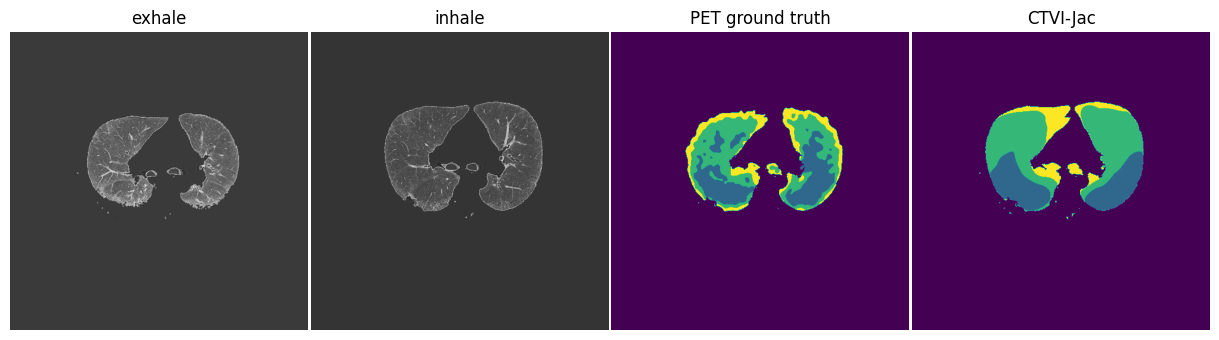

In [706]:
DISPLAY_IDX = 150

# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,4))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))
ax1.imshow(exp_arr[DISPLAY_IDX], cmap="gray")
ax1.set_title('exhale')
ax1.set_axis_off()

ax2.imshow(insp_arr[DISPLAY_IDX], cmap="gray")
ax2.set_title('inhale')
ax2.set_axis_off()

ax3.imshow(pet_labels_arr[DISPLAY_IDX])
ax3.set_title('PET ground truth')
ax3.set_axis_off()

ax4.imshow(ctvi_jac_label_arr[DISPLAY_IDX])
ax4.set_title('CTVI-Jac')
ax4.set_axis_off()

# ax5.imshow(nnunet_prediction_arr[DISPLAY_IDX])
# ax5.set_title('CTVI-nnU-Net')
# ax5.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

#### write out the images for processing with EvaluateSegmentation

In [707]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
EVALUATION_DIR = '{}/evaluation'.format(PREPROCESSED_BASE_DIR)
PATIENT_EVALUATION_DIR = '{}/Patient{:02d}'.format(EVALUATION_DIR, patient_id)

In [708]:
if not os.path.exists(EVALUATION_DIR):
    os.makedirs(EVALUATION_DIR)

if not os.path.exists(PATIENT_EVALUATION_DIR):
    os.makedirs(PATIENT_EVALUATION_DIR)

In [709]:
sitk.WriteImage(sitk.GetImageFromArray(pet_labels_arr), '{}/pet-label.mha'.format(PATIENT_EVALUATION_DIR))
sitk.WriteImage(sitk.GetImageFromArray(ctvi_jac_label_arr), '{}/ctvi-jac-label.mha'.format(PATIENT_EVALUATION_DIR))
sitk.WriteImage(sitk.GetImageFromArray(nnunet_prediction_arr), '{}/ctvi-nnunet.mha'.format(PATIENT_EVALUATION_DIR))

#### calculate the Spearman correlation of the unquantised images

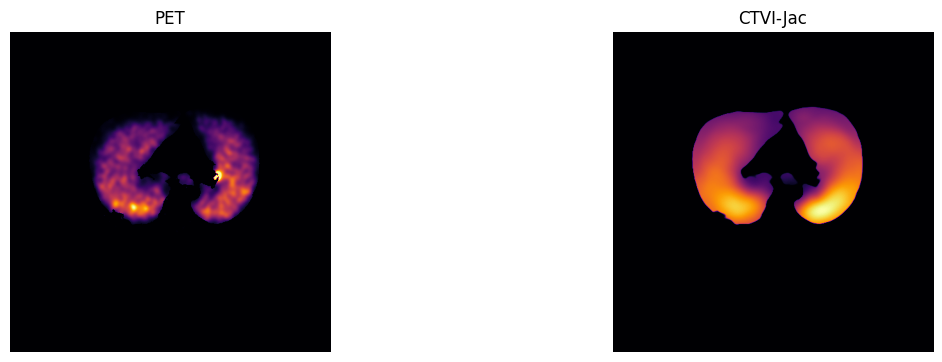

In [710]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.imshow(pet_arr[DISPLAY_IDX], cmap="inferno")
ax1.set_title('PET')
ax1.set_axis_off()

ax2.imshow(ctvi_jac_arr[DISPLAY_IDX], cmap="inferno")
ax2.set_title('CTVI-Jac')
ax2.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

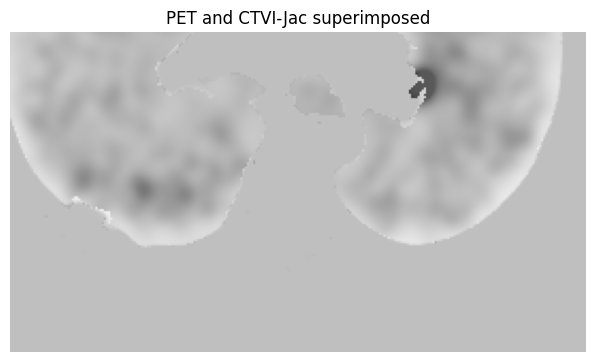

In [711]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15,4))
ax1.imshow(ctvi_jac_arr[DISPLAY_IDX,200:350,130:400], cmap="gist_gray", alpha=0.5)
ax1.imshow(pet_arr[DISPLAY_IDX,200:350,130:400], cmap="gist_yarg", alpha=0.5)
ax1.set_title('PET and CTVI-Jac superimposed')
ax1.set_axis_off()

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

In [712]:
sp = spearmanr(pet_arr[mask_arr], ctvi_jac_arr[mask_arr])
print('Spearman: {}'.format(np.round(sp[0],2)))
patient_eval_d = {'unquantised_spearman_correlation':sp[0]}

Spearman: 0.8


In [713]:
DATASET_EVALUATION_FILE = '{}/evaluation.pkl'.format(EVALUATION_DIR)

if os.path.isfile(DATASET_EVALUATION_FILE):
    with open(DATASET_EVALUATION_FILE, 'rb') as f:
        dataset_d = pickle.load(f)
else:
    dataset_d = {}

dataset_d[patient_id] = patient_eval_d

with open(DATASET_EVALUATION_FILE, 'wb') as f:
        pickle.dump(dataset_d, f)

In [714]:
dataset_d

{1: {'unquantised_spearman_correlation': 0.765597200011871},
 2: {'unquantised_spearman_correlation': 0.5841116774957084},
 3: {'unquantised_spearman_correlation': 0.4121572932640626},
 4: {'unquantised_spearman_correlation': 0.7406985321142072},
 5: {'unquantised_spearman_correlation': 0.36746768630103477},
 6: {'unquantised_spearman_correlation': 0.4816910517973112},
 7: {'unquantised_spearman_correlation': 0.6617734870745133},
 8: {'unquantised_spearman_correlation': 0.6784541901928374},
 9: {'unquantised_spearman_correlation': 0.618704225303245},
 10: {'unquantised_spearman_correlation': 0.7315623674035031},
 11: {'unquantised_spearman_correlation': 0.7004074453697051},
 12: {'unquantised_spearman_correlation': 0.4711854835913995},
 13: {'unquantised_spearman_correlation': 0.31804375479529323},
 14: {'unquantised_spearman_correlation': 0.7086699236956627},
 15: {'unquantised_spearman_correlation': 0.7106243221850376},
 16: {'unquantised_spearman_correlation': 0.7025955460966431},
 

In [715]:
spearman = []
spearman.append([value['unquantised_spearman_correlation'] for key, value in dataset_d.items()])

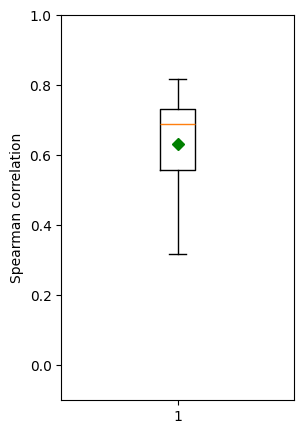

In [716]:
f, ax1 = plt.subplots()
f.set_figheight(5)
f.set_figwidth(3)

plt.margins(0.06)

red_circle = dict(markerfacecolor='red', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

bp = ax1.boxplot(spearman, showfliers=True, showmeans=True, meanprops=mean_shape)

# ax1.set_xticklabels(['high', 'medium', 'low'])
# plt.xlabel('lung function')
plt.ylabel('Spearman correlation')
ax1.set_ylim([-0.1, 1])
plt.show()